# Following the official PPO tutorial from TorchRL
Link: https://pytorch.org/tutorials/intermediate/reinforcement_ppo.html

In [32]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing

from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule, TensorDictSequential
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl import modules as trl_modules
from torchrl.envs.libs import register_gym_spec_conversion
from torchrl.collectors import SyncDataCollector, MultiaSyncDataCollector
from torchrl.data.tensor_specs import NonTensor
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter, TransformedEnv, DTypeCastTransform)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
from odyssey.nn.nethack.glyph_embedding import create_glyph_text_embedding
from odyssey.nn.nethack.map_embedding import MapEmbedding
from odyssey.nethack.transforms import render_tty_chars_transform

import os

# Hyperparameters

In [33]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

# Model
cache_folder = "./cache"
sentence_transformer_model = "all-MiniLM-L6-v2"
glyph_embedding_dim = 10
map_embedding_dim = 256

# Data collection
frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 1_000_000

# PPO
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = 0.2  # clip value for PPO loss: see the equation in the intro for more context.
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

# Environment

In [34]:
def create_env():
    base_env = GymEnv("NetHackScore-v0", device=device, categorical_action_encoding=True)
    env = TransformedEnv(
        base_env,
        Compose(
            DTypeCastTransform(torch.short, torch.long, in_keys=["glyphs"]),
            DoubleToFloat(),
            StepCounter(),
        ),
    )
    return env

env = create_env()

In [35]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: Composite(
    blstats: BoundedDiscrete(
        shape=torch.Size([27]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([27]), device=cuda:0, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([27]), device=cuda:0, dtype=torch.int64, contiguous=True)),
        device=cuda:0,
        dtype=torch.int64,
        domain=discrete),
    chars: UnboundedDiscrete(
        shape=torch.Size([21, 79]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([21, 79]), device=cuda:0, dtype=torch.uint8, contiguous=True),
            high=Tensor(shape=torch.Size([21, 79]), device=cuda:0, dtype=torch.uint8, contiguous=True)),
        device=cuda:0,
        dtype=torch.uint8,
        domain=discrete),
    colors: BoundedDiscrete(
        shape=torch.Size([21, 79]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([21, 79]), device=cuda:0, dtype=torch.uint8, contiguous=True),
            high=Tensor(shap

In [36]:
check_env_specs(env)

2025-03-11 19:35:38,987 [torchrl][INFO] check_env_specs succeeded!


In [37]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3]), device=cuda:0, dtype=torch.int64, is_shared=True),
        blstats: Tensor(shape=torch.Size([3, 27]), device=cuda:0, dtype=torch.int64, is_shared=True),
        chars: Tensor(shape=torch.Size([3, 21, 79]), device=cuda:0, dtype=torch.uint8, is_shared=True),
        colors: Tensor(shape=torch.Size([3, 21, 79]), device=cuda:0, dtype=torch.uint8, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        glyphs: Tensor(shape=torch.Size([3, 21, 79]), device=cuda:0, dtype=torch.int64, is_shared=True),
        inv_glyphs: Tensor(shape=torch.Size([3, 55]), device=cuda:0, dtype=torch.int16, is_shared=True),
        inv_letters: Tensor(shape=torch.Size([3, 55]), device=cuda:0, dtype=torch.uint8, is_shared=True),
        inv_oclasses: Tensor(shape=torch.Size([3, 55]), device=cuda:0, dtype=torch.uint8, is_shared=True),
        inv_strs: Tenso

# Architecture

In [38]:
sentence_transformer = SentenceTransformer(
    sentence_transformer_model,
    device=device,
    cache_folder=os.path.join(cache_folder, "sentence_transformer")
)

In [51]:
def create_net(output_dim: int, out_key: str):
    glyph_module = TensorDictModule(
        create_glyph_text_embedding(
            embedding_dim=glyph_embedding_dim,
            embedding_net=sentence_transformer,
            cache_folder=cache_folder
        ),
        in_keys=["glyphs"],
        out_keys=["glyph_embedding"]
    )

    map_module = TensorDictModule(
        MapEmbedding(
            embedding_dim=map_embedding_dim,
            input_glyph_embedding_dim=glyph_embedding_dim,
            use_cropped_view=False
        ),
        in_keys=["glyph_embedding", "blstats"],
        out_keys=["map_embedding"]
    )

    net = TensorDictSequential(
        glyph_module,
        map_module,
        TensorDictModule(
            nn.Sequential(
                nn.Tanh(),
                nn.LazyLinear(num_cells),
                nn.Tanh(),
                nn.LazyLinear(num_cells),
                nn.Tanh(),
                nn.LazyLinear(num_cells),
                nn.Tanh(),
                nn.LazyLinear(output_dim),
            ),
            in_keys=["map_embedding"],
            out_keys=[out_key],
        )
    )

    return net

logits_net = create_net(env.action_spec.n, "logits").to(device)
policy_module = ProbabilisticActor(
    module=logits_net,
    spec=env.action_spec,
    in_keys=["logits"],
    distribution_class=torch.distributions.Categorical,
    return_log_prob=True,
)

Loading cached glyph embeddings './cache/glyph_text_embeddings_26feb2a5cc6e8d260506d3319e4302474eb1f0a7d0fc816becedb9fbeb6f42ba.torch'...


In [52]:
value_module = create_net(1, "state_value").to(device)

Loading cached glyph embeddings './cache/glyph_text_embeddings_26feb2a5cc6e8d260506d3319e4302474eb1f0a7d0fc816becedb9fbeb6f42ba.torch'...


In [53]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.int64, is_shared=True),
        blstats: Tensor(shape=torch.Size([27]), device=cuda:0, dtype=torch.int64, is_shared=True),
        chars: Tensor(shape=torch.Size([21, 79]), device=cuda:0, dtype=torch.uint8, is_shared=True),
        colors: Tensor(shape=torch.Size([21, 79]), device=cuda:0, dtype=torch.uint8, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        glyph_embedding: Tensor(shape=torch.Size([21, 79, 10]), device=cuda:0, dtype=torch.float32, is_shared=True),
        glyphs: Tensor(shape=torch.Size([21, 79]), device=cuda:0, dtype=torch.int64, is_shared=True),
        inv_glyphs: Tensor(shape=torch.Size([55]), device=cuda:0, dtype=torch.int16, is_shared=True),
        inv_letters: Tensor(shape=torch.Size([55]), device=cuda:0, dtype=torch.uint8, is_shared=True),
        inv_oclasses: Tensor(shape=torch.Si

In [ ]:
logits = [policy_module(env.reset())["logits"] for _ in range(3)]

tensor(5, device='cuda:0')

# Data Collector

In [11]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

# collector = MultiaSyncDataCollector(
#     create_env_fn=[create_env, create_env],
#     policy=policy_module,
#     frames_per_batch=frames_per_batch,
#     total_frames=total_frames,
#     split_trajs=False,
#     device=device,
#     storing_device="cpu",
# )

# Replay Buffer

In [12]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Loss

In [13]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

# Training loop

In [14]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

eval cumulative reward: -10.0000 (init: -10.0000), eval step-count: 999, average reward=-0.0100 (init=-0.0100), step count (max): 4999, lr policy:  0.0000: 100%|██████████| 1000000/1000000 [5:43:07<00:00, 49.28it/s] 

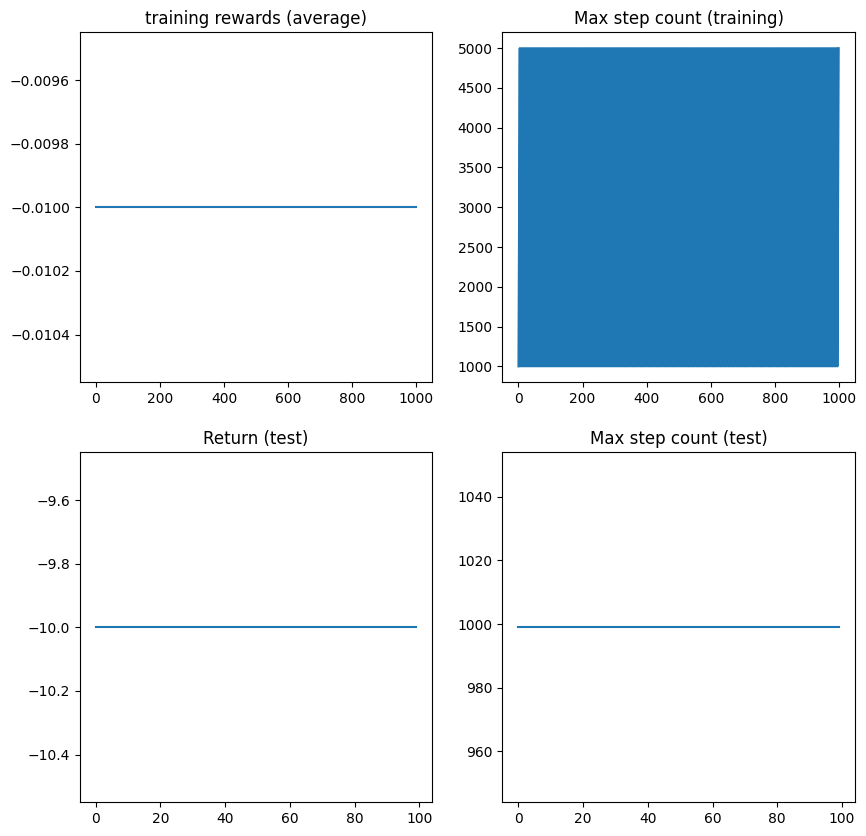

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

In [50]:
from torchrl.record import VideoRecorder
from torchrl.record.loggers.csv import CSVLogger

logger = CSVLogger(exp_name="final_agent", log_dir="videos", video_format="mp4")

recorded_env = TransformedEnv(
    GymEnv("NetHackScore-v0", device=device, categorical_action_encoding=True),
    Compose(
        render_tty_chars_transform,
        DTypeCastTransform(torch.short, torch.long, in_keys=["glyphs"]),
        DoubleToFloat(),
        StepCounter(),
        VideoRecorder(logger=logger, tag="run_video", skip=1)
    ),
)

_ = recorded_env.rollout(100, policy_module)
#_ = recorded_env.rollout(100)
recorded_env.transform.dump()